# 240923.ver


In [26]:
import os
import pickle
import glob
from datetime import datetime, timedelta
from konlpy.tag import Okt
import re
from tqdm import tqdm
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [22]:
def load_stopwords(file_path):
    """
    file_path 경로에서 불용어를 불러오는 함수
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()
    return stopwords



def preprocess_text(text, stopwords=None):
    """
    Okt를 사용한 텍스트 전처리 함수
    - 불용어 제거
    - 명사 추출
    """
    okt = Okt()
    # 정규 표현식을 사용한 숫자/특수문자 제거
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    nouns = okt.nouns(text)

    if stopwords:
        nouns = [word for word in nouns if word not in stopwords]
    
    # 길이가 1인 단어들 제거
    nouns = [word for word in nouns if len(word) > 1]

    processed_text = ' '.join(nouns)

    return processed_text


def load_and_merge_section_data(section_number, hours_back=9):
    """
    섹션 번호에 해당하는 모든 pkl 파일을 불러와서 기사 본문을 하나의 변수로 병합하는 함수
    현재 시간에서 -hours_back 시간 전까지의 파일만 병합
    """
    current_time = datetime.now()
    start_time = current_time - timedelta(hours=hours_back)

    valid_hours = []
    for hour in range(hours_back + 1): # 0부터 hours_back까지의 시간을 계산
        valid_hour = (start_time + timedelta(hours=hour)).strftime('%H')
        valid_hours.append(valid_hour)

    file_patterns = [f"./data/{section_number}/*_{hour}.pkl" for hour in valid_hours]

    merged_content = []
    for file_pattern in tqdm(file_patterns, desc=f"섹션 번호: {section_number} 파일"):
        file_list = glob.glob(file_pattern)

        for file_path in file_list:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                for article in data:
                    merged_content.append(article['content'])

    merged_document = ' '.join(merged_content)

    return merged_document


def process_sections(section_numbers, stopwords_file_path, hours_back=9):
    """
    주어진 섹션 번호 리스트에 대해 각 섹션별로 데이터를 병합하고 전처리하는 함수
    """
    # 불용어 로드
    print("불용어를 불러오는 중입니다...")
    stopwords = load_stopwords(stopwords_file_path)

    processed_documents = {}

    for section_number in tqdm(section_numbers, desc="섹션 처리중"):
        # 데이터 병합
        merged_content = load_and_merge_section_data(section_number, hours_back)

        # 텍스트 전처리
        print(f"{section_number}번 텍스트 전처리 중...")
        processed_text = preprocess_text(merged_content, stopwords)

        # 섹션 번호를 키로 하여 전처리된 문서를 저장
        processed_documents[section_number] = processed_text

    return processed_documents

def prepare_data_for_lda(doc):
    """
    LDA를 위한 데이터를 준비하는 함수
    - doc: 전처리된 텍스트 데이터 (단일 섹션의 텍스트)
    """
    # 전처리된 문서를 리스트로 변환
    text = doc.split()

    # 딕셔너리 생성
    dictionary = corpora.Dictionary([text])

    # 코퍼스 생성(단어의 빈도수로 변환된 텍스트 데이터)
    corpus = [dictionary.doc2bow(text)]

    return dictionary, corpus

def train_lda_model(dictionary, corpus, num_topics=5, passes=15):
    """
    LDA 모델을 학습하는 함수
    - dictionary: Gensim의 Dictionary 객체
    - corpus: Gensim의 코퍼스 객체
    - num_topics: 생성할 토픽의 수
    - passes: 학습 반복 횟수
    """
    # LDA 모델 학습
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         update_every=1,
                         passes=passes,
                         alpha='auto',
                         per_word_topics=True)
    
    return lda_model


def extract_topics_for_section(processed_docs, num_topics=1, num_words=10, passes=15):
    """
    각 섹션별로 토픽을 추출하는 함수
    - processed_docs: 전처리된 텍스트 데이터 (딕셔너리 형태, 섹션별로 저장됨)
    - num_topics: 생성할 토픽의 수
    - num_words: 각 토픽에 대해 출력할 단어 수
    - passes: 학습 반복 횟수
    """
    section_topics = {}

    for section, doc in tqdm(processed_docs.items(), desc="각 섹션별로 토픽을 추출합니다."):
        # 데이터 준비
        dictionary, corpus = prepare_data_for_lda(doc)

        # LDA 모델 학습
        lda_model = train_lda_model(dictionary, corpus, num_topics=num_topics, passes=passes)

        # 토픽 추출
        topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
        section_topics[section] = topics

    return section_topics



def print_section_topics(section_topics, num_words=10):
    """
    각 섹션별로 추출된 토픽을 출력하는 함수
    - section_topics: 섹션별로 학습된 토픽 데이터
    - num_words: 각 토픽에 대해 출력할 단어 수
    """
    for section, topics in section_topics.items():
        print(f"\nSection {section} Topics:")
        for i, topic in enumerate(topics):
            topic_words = [word for word, _ in topic[1]]  # topic[1]이 단어-가중치 리스트임
            print(f"  Topic {i}: {', '.join(topic_words[:num_words])}")


def create_word_cloud_with_frequency(lda_model, topic_num):
    """
    특정 토픽에 대해 워드 클라우드를 생성하고, 각 단어의 빈도수를 출력하는 함수
    - lda_model: 학습된 LDA 모델
    - topic_num: 워드 클라우드를 생성할 토픽 번호
    """
    # 토픽 내 단어와 가중치 추출
    topic_words = dict(lda_model.show_topic(topic_num, topn=30)) # 상위 30개 단어
    # font_path 확인 필요
    wordcloud = WordCloud(font_path='./data/NanumGothic.ttf', background_color='white').generate_from_frequencies(topic_words)

    # 워드 클라우드 시각화
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    # 각 단어와 빈도수 출력
    print(f"토픽 {topic_num}의 단어 가중치(빈도수):")
    for word, freq in topic_words.items():
        print(f"{word}: {freq}")




In [23]:
# 사용 예시
section_numbers = [100, 101, 102, 103, 104, 105]
stopwords_file_path = './data/korean_stopwords.txt'
processed_docs = process_sections(section_numbers, stopwords_file_path)

section_topics = extract_topics_for_section(processed_docs, num_topics=3, num_words=10, passes=15)
print_section_topics(section_topics)

불용어를 불러오는 중입니다...


섹션 번호: 100 파일: 100%|██████████| 10/10 [00:00<00:00, 9998.34it/s]

100번 텍스트 전처리 중...



섹션 번호: 101 파일: 100%|██████████| 10/10 [00:00<00:00, 5531.19it/s]


101번 텍스트 전처리 중...


섹션 번호: 102 파일: 100%|██████████| 10/10 [00:00<00:00, 4999.17it/s]


102번 텍스트 전처리 중...


섹션 번호: 103 파일: 100%|██████████| 10/10 [00:00<00:00, 4999.17it/s]


103번 텍스트 전처리 중...


섹션 번호: 104 파일: 100%|██████████| 10/10 [00:00<00:00, 4999.17it/s]


104번 텍스트 전처리 중...


섹션 처리중: 100%|██████████| 6/6 [00:05<00:00,  1.33it/s]

105번 텍스트 전처리 중...


각 섹션별로 토픽을 추출합니다.: 100%|██████████| 6/6 [00:00<00:00, 12.74it/s]


Section 100 Topics:
  Topic 0: 대통령, 김우영, 체코, 여사, 국민, 의원, 대표, 김건희, 원전, 민주당

Section 101 Topics:
  Topic 0: 금리, 시장, 투자, 반도체, 인하, 미국, 상승, 지수, 하이닉스, 증권

Section 102 Topics:
  Topic 0: 경찰, 지난, 남성, 철도, 선생님, 혐의, 사진, 한국, 서울, 학생

Section 103 Topics:
  Topic 0: 로봇, 취소, 지역, 사람, 효과, 도움, 제주, 섭취, 사진, 때문

Section 104 Topics:
  Topic 0: 미국, 대통령, 해리스, 달러, 이스라엘, 트럼프, 부통령, 금리, 대선, 후보

Section 105 Topics:
  Topic 0: 시장, 애플, 중국, 아이폰, 분석, 시리즈, 코로나바이러스, 판매량, 게임, 야생동물


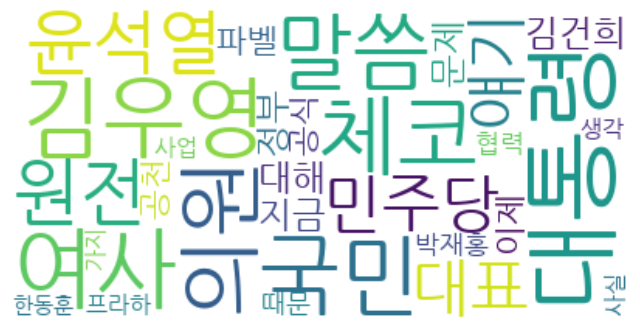

토픽 0의 단어 가중치(빈도수):
대통령: 0.0006471326923929155
김우영: 0.0005319261690601707
여사: 0.0005231221439316869
체코: 0.0005124134477227926
국민: 0.0005079793627373874
의원: 0.00049806316383183
말씀: 0.00048505584709346294
원전: 0.00048480278928764164
윤석열: 0.0004815797437913716
민주당: 0.0004798587178811431
대표: 0.0004785206983797252
얘기: 0.00047272691153921187
김건희: 0.000472318846732378
지금: 0.00047063155216164887
대해: 0.00046855368418619037
정부: 0.00046430795919150114
문제: 0.00046120499609969556
파벨: 0.0004610777832567692
공천: 0.00046075283898971975
공식: 0.0004606977163348347
이제: 0.00046054055565036833
박재홍: 0.00045878058881498873
협력: 0.0004528817080426961
때문: 0.0004521697701420635
프라하: 0.00045179916196502745
사실: 0.000449583021691069
가지: 0.000449264858616516
사업: 0.0004483810917008668
생각: 0.0004479903436731547
한동훈: 0.00044775279820896685


In [27]:
# 첫 번째 섹션 데이터를 LDA 모델에 적합하게 준비
dictionary, corpus = prepare_data_for_lda(processed_docs[100])  # 100번 섹션을 예시로 사용

# LDA 모델 학습
lda_model = train_lda_model(dictionary, corpus, num_topics=5, passes=15)

# 예시: 첫 번째 토픽에 대한 워드 클라우드 생성 및 단어 가중치(빈도수) 출력
create_word_cloud_with_frequency(lda_model, topic_num=0)